<a href="https://colab.research.google.com/github/Navya-S/ERA/blob/main/ERA1S7F5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from model import Model4
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                      #  transforms.CenterCrop(20),
                                      #  transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [5]:
class Model4(nn.Module):
    def __init__(self):
        super(Model4, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False), # 28>26 |1>3
            nn.BatchNorm2d(8),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False), # 26>24 |3>5
            nn.BatchNorm2d(8),
            nn.ReLU()
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False), # 24>22 | 5>7
            nn.BatchNorm2d(8),
            nn.ReLU()
        )

        self.pool1 = nn.MaxPool2d(2, 2) #22>11 |7>8

        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False), #11>9 |8>12
            nn.BatchNorm2d(16),
            nn.ReLU()
        )

        # self.pool1 = nn.MaxPool2d(2, 2) # 8>4 | 14>16

        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False), # 9>7 | 12>16
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3,3), padding=0, bias=False), # 7>5 | 16>20
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=5) # 20>28
        )

        self.conv7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1,1), padding=0, bias=False) # 1>1 | 28>28
            # nn.ReLU()
        )
        # self.conv1 = nn.Conv2d(1, 32, 3, padding=1) # 28>28 | 3
        # self.conv2 = nn.Conv2d(32, 64, 3, padding=1) # 28 > 28 |  5
        # self.pool1 = nn.MaxPool2d(2, 2) # 28 > 14 | 6
        # self.conv3 = nn.Conv2d(64, 128, 3, padding=1) # 14> 14 | 12
        # self.conv4 = nn.Conv2d(128, 256, 3, padding=1) #14 > 14 | 14
        # self.pool2 = nn.MaxPool2d(2, 2) # 14 > 7 | 28
        # self.conv5 = nn.Conv2d(256, 512, 3) # 7 > 5 | 30
        # self.conv6 = nn.Conv2d(512, 1024, 3) # 5 > 3 | 32 | 3*3*1024 | 3x3x1024x10 |
        # self.conv7 = nn.Conv2d(1024, 10, 3) # 3 > 1 | 34 | > 1x1x10

    def forward(self, x):

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.pool1(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.gap(x)
        x = self.conv7(x)
        # x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

        # x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))
        # x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))
        # x = F.relu(self.conv6(F.relu(self.conv5(x))))
        # # x = F.relu(self.conv7(x))
        # x = self.conv7(x)
        # x = x.view(-1, 10) #1x1x10> 10
        # return F.log_softmax(x, dim=-1)

In [6]:
# !pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Model4().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
            Conv2d-4            [-1, 8, 24, 24]             576
       BatchNorm2d-5            [-1, 8, 24, 24]              16
              ReLU-6            [-1, 8, 24, 24]               0
            Conv2d-7            [-1, 8, 22, 22]             576
       BatchNorm2d-8            [-1, 8, 22, 22]              16
              ReLU-9            [-1, 8, 22, 22]               0
        MaxPool2d-10            [-1, 8, 11, 11]               0
           Conv2d-11             [-1, 16, 9, 9]           1,152
      BatchNorm2d-12             [-1, 16, 9, 9]              32
             ReLU-13             [-1, 16, 9, 9]               0
           Conv2d-14             [

# Training and Testing

All right, so we have 6.3M params, and that's too many, we know that. But the purpose of this notebook is to set things right for our future experiments.

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [7]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [8]:
model =  Model4().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.06158885359764099 Batch_id=468 Accuracy=85.45: 100%|██████████| 469/469 [00:14<00:00, 31.85it/s]



Test set: Average loss: 0.1083, Accuracy: 9756/10000 (97.56%)

EPOCH: 1


Loss=0.05089602991938591 Batch_id=468 Accuracy=97.80: 100%|██████████| 469/469 [00:14<00:00, 33.33it/s] 



Test set: Average loss: 0.0718, Accuracy: 9804/10000 (98.04%)

EPOCH: 2


Loss=0.04698028787970543 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:14<00:00, 31.98it/s] 



Test set: Average loss: 0.0527, Accuracy: 9863/10000 (98.63%)

EPOCH: 3


Loss=0.020520202815532684 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:14<00:00, 33.43it/s] 



Test set: Average loss: 0.0415, Accuracy: 9885/10000 (98.85%)

EPOCH: 4


Loss=0.02373136393725872 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:14<00:00, 31.68it/s] 



Test set: Average loss: 0.0400, Accuracy: 9878/10000 (98.78%)

EPOCH: 5


Loss=0.022286431863904 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:14<00:00, 33.35it/s]   



Test set: Average loss: 0.0357, Accuracy: 9893/10000 (98.93%)

EPOCH: 6


Loss=0.010524816811084747 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:14<00:00, 31.86it/s]



Test set: Average loss: 0.0278, Accuracy: 9912/10000 (99.12%)

EPOCH: 7


Loss=0.08632754534482956 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:14<00:00, 33.38it/s]  



Test set: Average loss: 0.0301, Accuracy: 9906/10000 (99.06%)

EPOCH: 8


Loss=0.023656710982322693 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:14<00:00, 31.89it/s] 



Test set: Average loss: 0.0357, Accuracy: 9893/10000 (98.93%)

EPOCH: 9


Loss=0.072198785841465 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:13<00:00, 33.50it/s]    



Test set: Average loss: 0.0273, Accuracy: 9921/10000 (99.21%)

EPOCH: 10


Loss=0.00852244533598423 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:14<00:00, 31.72it/s]  



Test set: Average loss: 0.0248, Accuracy: 9931/10000 (99.31%)

EPOCH: 11


Loss=0.008649962954223156 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:14<00:00, 33.27it/s] 



Test set: Average loss: 0.0262, Accuracy: 9920/10000 (99.20%)

EPOCH: 12


Loss=0.002438923576846719 Batch_id=468 Accuracy=99.40: 100%|██████████| 469/469 [00:14<00:00, 32.00it/s] 



Test set: Average loss: 0.0259, Accuracy: 9919/10000 (99.19%)

EPOCH: 13


Loss=0.023770615458488464 Batch_id=468 Accuracy=99.43: 100%|██████████| 469/469 [00:13<00:00, 33.91it/s] 



Test set: Average loss: 0.0265, Accuracy: 9914/10000 (99.14%)

EPOCH: 14


Loss=0.009547754190862179 Batch_id=468 Accuracy=99.43: 100%|██████████| 469/469 [00:14<00:00, 31.53it/s] 



Test set: Average loss: 0.0297, Accuracy: 9908/10000 (99.08%)



In [9]:
t = [t_items.item() for t_items in train_losses]

Text(0.5, 1.0, 'Test Accuracy')

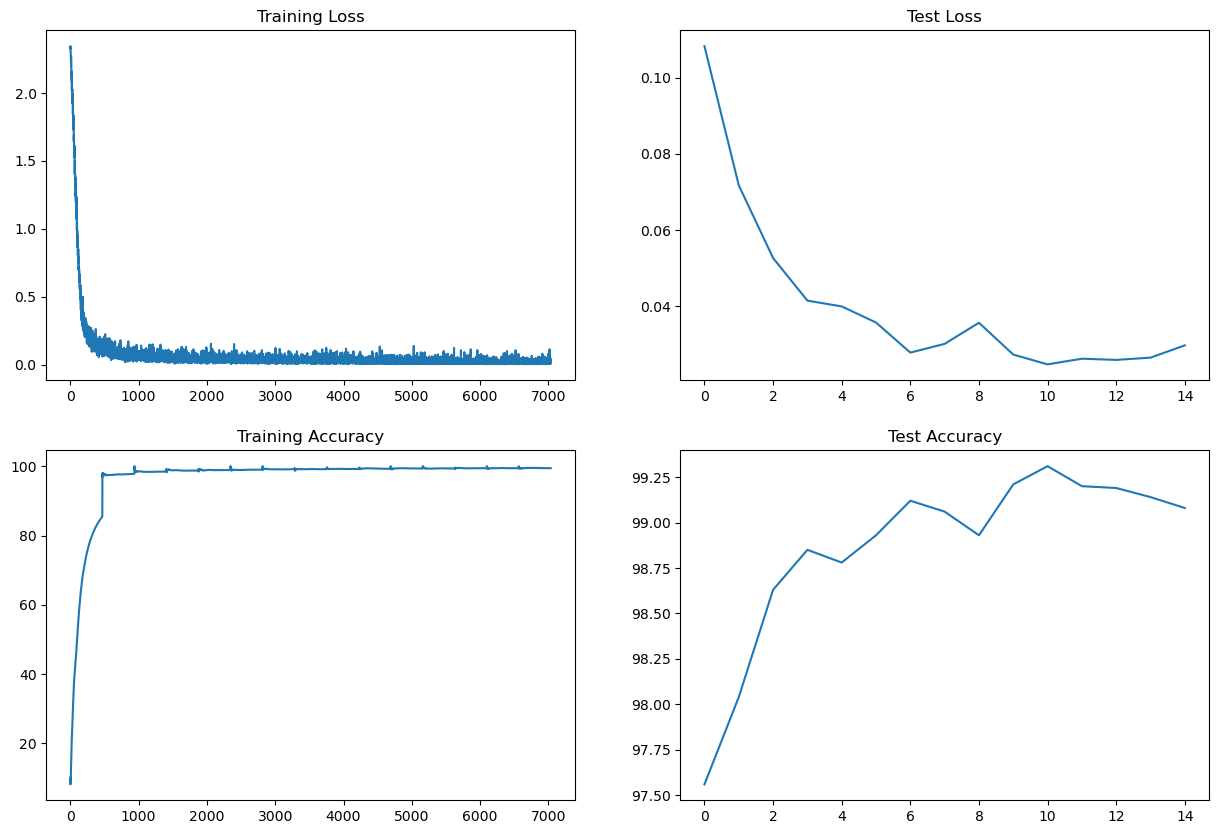

In [10]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")